In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .master("local[*]")\
    .config("spark.driver.host", "localhost") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 19:13:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
hdfs_path = "hdfs://localhost:9000/user/hadoop/jobfiles/processed_data_linkedin.csv"

In [4]:
df = spark.read.option("header", True) \
    .option("inferSchema", True) \
    .option("delimiter", ",") \
    .option("multiLine", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("mode", "DROPMALFORMED") \
    .csv(hdfs_path)

In [5]:
df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+--------------------------+-----------+-------+---------------+--------------------------------------------------------------------------+-------------------------------------+----------------------------------+----------+---------------+--------------+--------------------------------+----------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
df.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- job_summary: string (nullable = true)



In [7]:
df.describe().show()

25/04/26 19:13:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+-----------+--------------+----------------+----------+--------+--------------------+--------------------+
|summary|            job_link|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|search_city|search_country| search_position| job_level|job_type|          job_skills|         job_summary|
+-------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+-----------+--------------+----------------+----------+--------+--------------------+--------------------+
|  count|              863708|     863708| 863708|         863708|              863708|              863708|              863708|     863708|        863708|          863708|    863708|  863708|              863708|              863708|
|   mean|                NULL|       NULL|   NULL|      

In [52]:
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import DoubleType, FloatType
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from pyspark.sql.functions import col


null_counts = []

for column in df.columns:
    dtype = dict(df.dtypes)[column]
    
    if dtype in ['double', 'float']:
        null_count = count(when(col(column).isNull() | isnan(col(column)), column)).alias(column)
    else:
        null_count = count(when(col(column).isNull(), column)).alias(column)
        
    null_counts.append(null_count)

df.select(null_counts).show()

+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|job_skills|job_summary|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+
|       0|                  0|          0|      0|              0|        0|      0|           0|         0|          0|             0|              0|        0|       0|         0|          0|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+-----------+



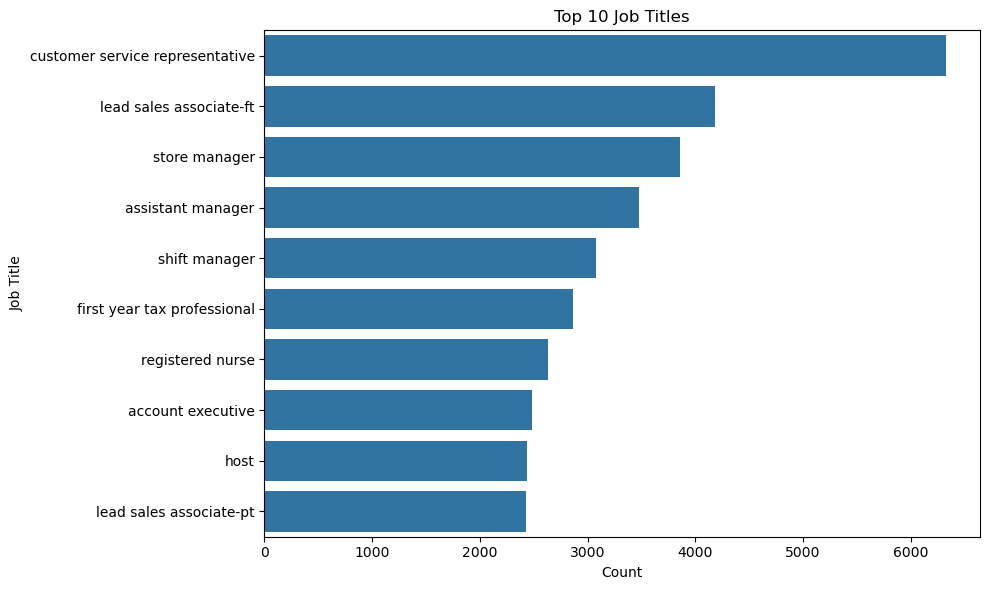

In [ ]:
# Counting the job tititles
job_title_counts = df.groupBy("job_title").count().orderBy("count", ascending=False).limit(10)

job_title_pd = job_title_counts.toPandas()
import matplotlib.pyplot as plt
import seaborn as sns
#Plotting top10 job titles
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='job_title', data=job_title_pd)
plt.title("Top 10 Job Titles")
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()


In [ ]:
# Row counts
row_count = df.count()
print(f"Total rows: {row_count}")

Total rows: 863708


In [12]:
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, to_date, trim, when, count, isnull
from pyspark.sql import functions as F 
import matplotlib.pyplot as plt
import seaborn as sns

df = (df
      .withColumn("last_processed_time", 
                 F.to_timestamp(F.col("last_processed_time"), "yyyy-MM-dd HH:mm:ss.SSSSSSX"))

      .withColumn("got_summary", F.col("got_summary") == "t")
      .withColumn("got_ner", F.col("got_ner") == "t")
      .withColumn("is_being_worked", F.col("is_being_worked") == "f")

      .withColumn("first_seen", F.to_date(F.col("first_seen"), "yyyy-MM-dd"))

      .withColumn("job_title", F.trim(F.col("job_title")))
      .withColumn("company", F.trim(F.col("company"))))

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull, explode, split, lower
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("JobDataAnalysis") \
    .getOrCreate()


25/04/26 19:16:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
for col_name in numeric_cols:
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

print("Outliers removed using IQR method.")


Outliers removed using IQR method.


In [ ]:
if "salary" in df.columns:
    avg_salary = df.groupBy("job_title").agg(F.avg("salary").alias("avg_salary")).orderBy("avg_salary", ascending=False)
    avg_salary.show(10)


In [ ]:
#Jobs per company
jobs_per_company = df.groupBy("company").count().orderBy("count", ascending=False)
jobs_per_company.show(10)


+--------------------+-----+
|             company|count|
+--------------------+-----+
|     health ecareers|23731|
|   jobs for humanity|16332|
|   travelnursesource| 9037|
|      dollar general| 8278|
|      energy jobline| 5735|
|gotham enterprise...| 5728|
|               jobot| 5451|
|        practicelink| 5284|
|      volunteermatch| 4731|
|             doccafe| 4625|
+--------------------+-----+
only showing top 10 rows



In [19]:
jobs_per_company.show(20)

+--------------------+-----+
|             company|count|
+--------------------+-----+
|     health ecareers|23731|
|   jobs for humanity|16332|
|   travelnursesource| 9037|
|      dollar general| 8278|
|      energy jobline| 5735|
|gotham enterprise...| 5728|
|               jobot| 5451|
|        practicelink| 5284|
|      volunteermatch| 4731|
|             doccafe| 4625|
|       clearancejobs| 4454|
|          mcdonald's| 4430|
|             walmart| 3993|
|         cybercoders| 3722|
|            circle k| 3576|
|              target| 3284|
|     texas roadhouse| 3086|
|u.s. department o...| 3069|
|           h&r block| 3011|
|        michael page| 2903|
+--------------------+-----+
only showing top 20 rows



In [ ]:
top_companies = jobs_per_company.limit(10).collect()

for row in top_companies:
    print(f"{row['company']:<30} | {'█' * (row['count']//500)} {row['count']}")

health ecareers                | ███████████████████████████████████████████████ 23731
jobs for humanity              | ████████████████████████████████ 16332
travelnursesource              | ██████████████████ 9037
dollar general                 | ████████████████ 8278
energy jobline                 | ███████████ 5735
gotham enterprises ltd         | ███████████ 5728
jobot                          | ██████████ 5451
practicelink                   | ██████████ 5284
volunteermatch                 | █████████ 4731
doccafe                        | █████████ 4625


In [ ]:
top_locations = df.groupBy("job_location").count().orderBy("count", ascending=False)

top_10_locations = top_locations.limit(10).collect()

print("\nTop 10 Job Locations:\n")
for row in top_10_locations:
    print(f"{row['job_location']:<30} | {'█' * (row['count'] // 500)} {row['count']}")



Top 10 Job Locations:

new york, ny                   | ███████████████ 7964
london, england, united kingdom | ██████████████ 7404
houston, tx                    | █████████████ 6916
los angeles, ca                | ████████████ 6497
chicago, il                    | ████████████ 6486
atlanta, ga                    | ████████████ 6024
austin, tx                     | ██████████ 5361
boston, ma                     | ██████████ 5191
dallas, tx                     | ██████████ 5033
san antonio, tx                | █████████ 4707


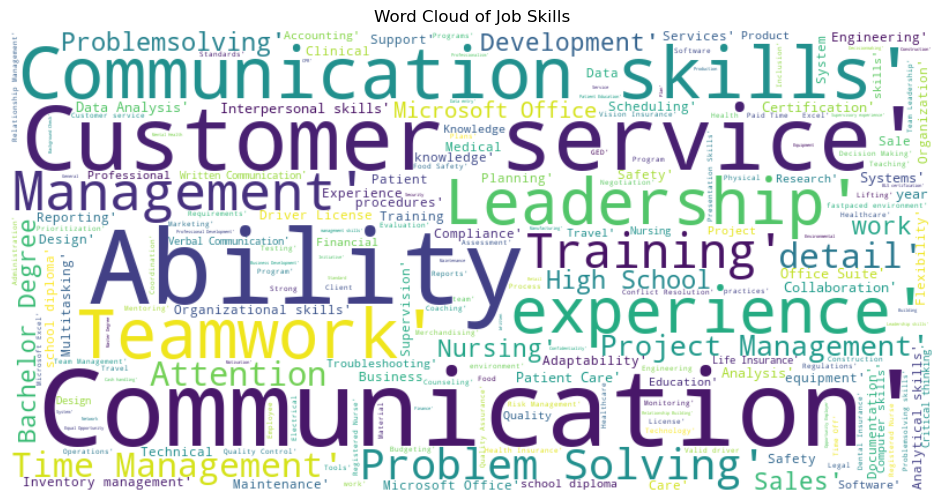

In [ ]:
from pyspark.sql.functions import col, explode, split, trim

df_skills = df.withColumn("skill", explode(split(col("job_skills"), ",")))

df_skills = df_skills.withColumn("skill", trim(col("skill")))

df_skills = df_skills.filter(col("skill") != "")

df_skills_sampled = df_skills.sample(fraction=0.01, seed=42)

skills_list = [row['skill'] for row in df_skills_sampled.select('skill').collect()]

skills_text = " ".join(skills_list)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Job Skills')
plt.show()


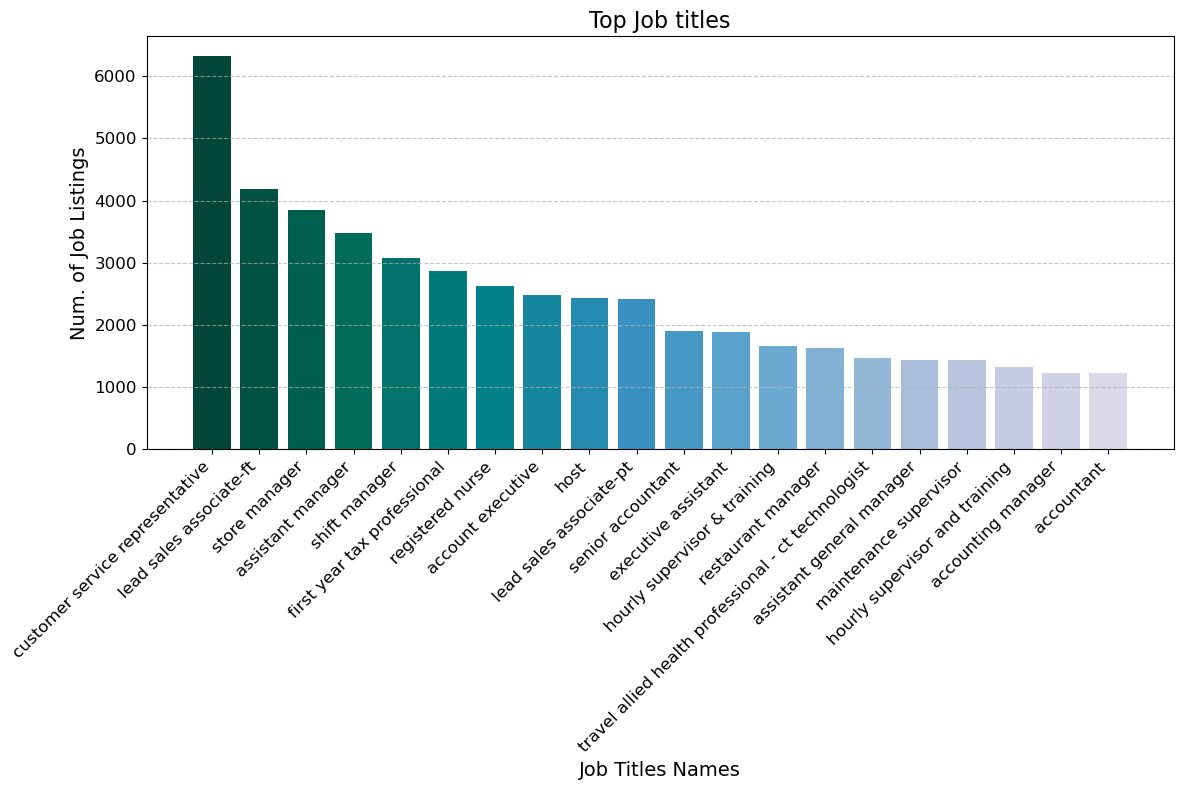

In [53]:

top_jobs_df = df.groupBy("job_title").count().orderBy(col("count").desc()).limit(20)

top_jobs = top_jobs_df.collect()

job_titles = [row['job_title'] for row in top_jobs]
counts = [row['count'] for row in top_jobs]

colors = plt.cm.PuBuGn(np.linspace(1, 0.2, len(top_jobs)))

#CREATING BAR PLOT
plt.figure(figsize=(12, 8))
plt.bar(job_titles, counts, color=colors)

#TITLES AND LAYOUT
plt.title('Top Job titles', fontsize=16)
plt.xlabel('Job Titles Names', fontsize=14)
plt.ylabel('Num. of Job Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


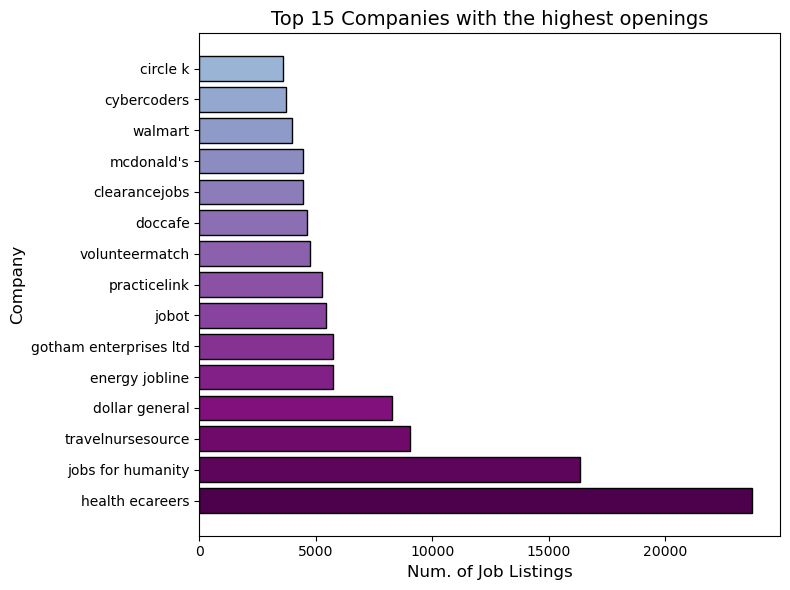

In [54]:
top_companies_df = df.groupBy("company").count().orderBy(col("count").desc()).limit(15)

top_companies = top_companies_df.collect()

company_names = [row['company'] for row in top_companies]
counts = [row['count'] for row in top_companies]
colors = plt.cm.BuPu(np.linspace(1, 0.4, len(top_companies)))


plt.figure(figsize=(8,6))
bars = plt.barh(company_names, counts, color=colors, edgecolor='black')

plt.title('Top 15 Companies with the highest openings', fontsize=14)
plt.xlabel('Num. of Job Listings', fontsize=12)
plt.ylabel('Company', fontsize=12)
plt.tight_layout()
plt.show()


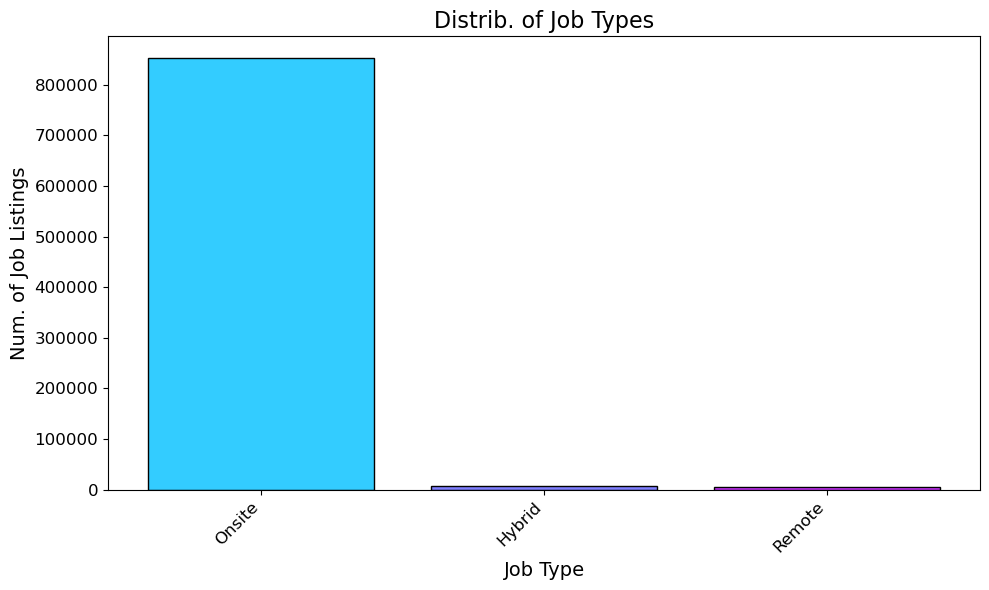

In [55]:
job_types_df = df.groupBy("job_type").count().orderBy(col("count").desc())

job_types = job_types_df.collect()

job_type_labels = [row['job_type'] for row in job_types]
counts = [row['count'] for row in job_types]

colors = plt.cm.cool(np.linspace(0.2, 0.8, len(job_types)))

plt.figure(figsize=(10, 6))
plt.bar(job_type_labels, counts, color=colors, edgecolor='black')
plt.title('Distrib. of Job Types', fontsize=16)
plt.xlabel('Job Type', fontsize=14)
plt.ylabel('Num. of Job Listings', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(style='plain', axis='y')

# 8. Layout adjustment
plt.tight_layout()

# 9. Show plot
plt.show()


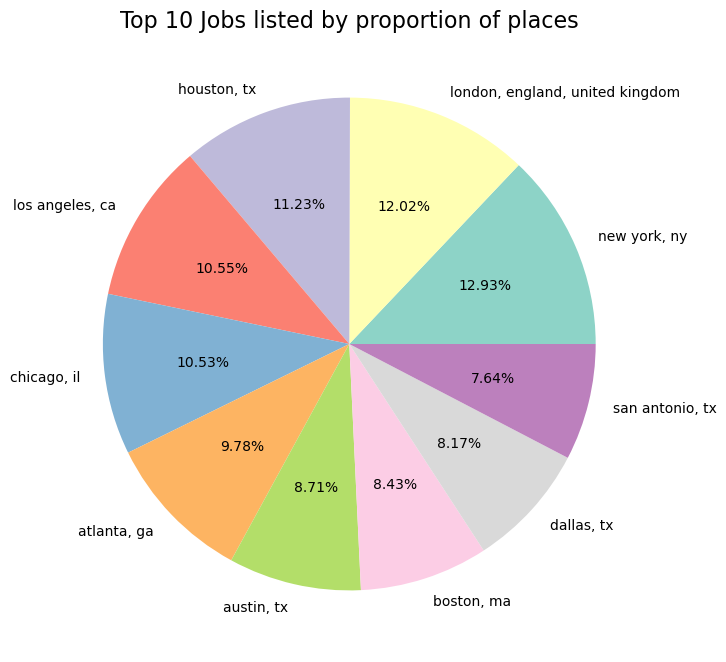

25/04/27 01:40:37 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1069121 ms exceeds timeout 120000 ms
25/04/27 01:40:37 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/27 01:56:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from pyspark.sql.functions import col

job_location_df = df.groupBy("job_location").count().orderBy(col("count").desc()).limit(10)

job_location_counts = job_location_df.collect()

location_labels = [row['job_location'] for row in job_location_counts]
counts = [row['count'] for row in job_location_counts]

plt.figure(figsize=(8, 8))
plt.pie(counts, 
        labels=location_labels, 
        autopct='%1.2f%%', 
        colors=plt.cm.Set3.colors)
plt.title('Top 10 Jobs listed by proportion of places', fontsize=16)
plt.show()


Spark ML

In [ ]:
#Train Test Split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#String Indexer
indexer_joblevel = StringIndexer(inputCol="job_level", outputCol="job_level_index")

#vector Assembler
assembler = VectorAssembler(inputCols=['got_summary', 'got_ner', 'is_being_worked'], outputCol='features')

#Random Forest Classifier
rf_joblevel = RandomForestClassifier(featuresCol="features", labelCol="job_level_index", seed=42)

pipeline_joblevel = Pipeline(stages=[indexer_joblevel, assembler, rf_joblevel])

# Using Param Grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf_joblevel.numTrees, [10, 20, 30]) \
    .addGrid(rf_joblevel.maxDepth, [5, 10, 15]) \
    .build()

# Creating Crossvalidator
crossval = CrossValidator(estimator=pipeline_joblevel,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="job_level_index", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)
#Training
cv_model_joblevel = crossval.fit(train_df)

predictions_cv_joblevel = cv_model_joblevel.transform(test_df)

#Taking best model
evaluator_cv = MulticlassClassificationEvaluator(labelCol="job_level_index", predictionCol="prediction", metricName="accuracy")
best_accuracy = evaluator_cv.evaluate(predictions_cv_joblevel)

print(f"Best Job Level Classification Accuracy after Hyperparameter Tuning: {best_accuracy}")


25/04/26 19:37:34 WARN MemoryStore: Not enough space to cache rdd_238_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:37:34 WARN BlockManager: Persisting block rdd_238_0 to disk instead.
25/04/26 19:37:42 WARN MemoryStore: Not enough space to cache rdd_238_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:37:42 WARN MemoryStore: Not enough space to cache rdd_238_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:37:44 WARN MemoryStore: Not enough space to cache rdd_238_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:37:44 WARN MemoryStore: Not enough space to cache rdd_238_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:37:45 WARN MemoryStore: Not enough space to cache rdd_238_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:37:46 WARN MemoryStore: Not enough space to cache rdd_238_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:38:12 WARN MemoryStore: Not enough space to cache rdd_298_0 in memory! (computed 416.8 MiB so far)
25/04/26 19:38:12 WARN BlockMan

Best Job Level Classification Accuracy after Hyperparameter Tuning: 0.8689162278435448


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

#String Indexer
indexer_jobtype = StringIndexer(inputCol="job_type", outputCol="job_type_index")

# Setup Assembler
assembler = VectorAssembler(inputCols=['got_summary', 'got_ner', 'is_being_worked'], outputCol='features')

# Random Forest Classifier for jobtype
rf_jobtype = RandomForestClassifier(featuresCol="features", labelCol="job_type_index", seed=42)

pipeline_jobtype = Pipeline(stages=[indexer_jobtype, assembler, rf_jobtype])

# Building Param Grid
paramGrid_jobtype = ParamGridBuilder() \
    .addGrid(rf_jobtype.numTrees, [10, 20, 30]) \
    .addGrid(rf_jobtype.maxDepth, [5, 10, 15]) \
    .build()

# Creating crossvalidator
crossval_jobtype = CrossValidator(estimator=pipeline_jobtype,
                                  estimatorParamMaps=paramGrid_jobtype,
                                  evaluator=MulticlassClassificationEvaluator(labelCol="job_type_index", predictionCol="prediction", metricName="accuracy"),
                                  numFolds=3)

# Training
cv_model_jobtype = crossval_jobtype.fit(train_df)

# Predictions
predictions_cv_jobtype = cv_model_jobtype.transform(test_df)

#Taking Best model
evaluator_cv_jobtype = MulticlassClassificationEvaluator(labelCol="job_type_index", predictionCol="prediction", metricName="accuracy")
best_accuracy_jobtype = evaluator_cv_jobtype.evaluate(predictions_cv_jobtype)

print(f"Best Job Type Classification Accuracy after Hyperparameter Tuning: {best_accuracy_jobtype}")


25/04/26 19:47:48 WARN MemoryStore: Not enough space to cache rdd_2083_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:47:48 WARN BlockManager: Persisting block rdd_2083_0 to disk instead.
25/04/26 19:47:57 WARN MemoryStore: Not enough space to cache rdd_2083_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:47:57 WARN MemoryStore: Not enough space to cache rdd_2083_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:47:58 WARN MemoryStore: Not enough space to cache rdd_2083_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:47:58 WARN MemoryStore: Not enough space to cache rdd_2083_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:48:00 WARN MemoryStore: Not enough space to cache rdd_2083_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:48:01 WARN MemoryStore: Not enough space to cache rdd_2083_0 in memory! (computed 427.0 MiB so far)
25/04/26 19:48:26 WARN MemoryStore: Not enough space to cache rdd_2134_0 in memory! (computed 416.8 MiB so far)
25/04/26 19:48:26 WARN

Best Job Type Classification Accuracy after Hyperparameter Tuning: 0.9871517234572489


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

#Taking Kmeans clustering
kmeans = KMeans(featuresCol="features", k=3, seed=42)  #Taking k=3

pipeline_cluster = Pipeline(stages=[assembler, kmeans])

# Training
model_cluster = pipeline_cluster.fit(train_df)

#Predicting
predictions_cluster = model_cluster.transform(test_df)

#prediction cluster
predictions_cluster.select('features', 'prediction').show(5)


25/04/26 19:36:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/26 19:36:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 19:36:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 19:36:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 19:36:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 19:36:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 19:36:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 19:36:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/26 19:36:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedK

+-------------+----------+
|     features|prediction|
+-------------+----------+
|[1.0,1.0,1.0]|         0|
|[1.0,1.0,1.0]|         0|
|[1.0,1.0,1.0]|         0|
|[1.0,1.0,1.0]|         0|
|[1.0,1.0,1.0]|         0|
+-------------+----------+
only showing top 5 rows



In [ ]:
#Saving the best model for the joblevel to hdfs
cv_model_joblevel.bestModel.write().overwrite().save("hdfs://localhost:9000/user/hadoop/models/cv_model_joblevel")

#Saving the best model for the jobtype to hdfs
cv_model_jobtype.bestModel.write().overwrite().save("hdfs://localhost:9000/user/hadoop/models/cv_model_jobtype")

#Saving the clustering model
model_cluster.write().overwrite().save("hdfs://localhost:9000/user/hadoop/models/kmeans_cluster_model")

print("Models successfully saved to HDFS.")


✅ Models successfully saved to HDFS.


In [ ]:
#Saving joblevel predictions
predictions_cv_joblevel.write.mode("overwrite").parquet("hdfs://localhost:9000/user/hadoop/predictions/joblevel_predictions")

#Saving jobtype predictions
predictions_cv_jobtype.write.mode("overwrite").parquet("hdfs://localhost:9000/user/hadoop/predictions/jobtype_predictions")

#Saving the cluster predictions
predictions_cluster.write.mode("overwrite").parquet("hdfs://localhost:9000/user/hadoop/predictions/cluster_predictions")

print("Predictions successfully saved to HDFS.!")


✅ Predictions successfully saved to HDFS.


In [ ]:
import os

with open("joblevel_accuracy.txt", "w") as f:
    f.write(f"Best Job Level Classification Accuracy after Hyperparameter Tuning: {best_accuracy}\n")

with open("jobtype_accuracy.txt", "w") as f:
    f.write(f"Best Job Type Classification Accuracy after Hyperparameter Tuning: {best_accuracy_jobtype}\n")

os.system("hdfs dfs -put -f joblevel_accuracy.txt /user/hadoop/metrics/")
os.system("hdfs dfs -put -f jobtype_accuracy.txt /user/hadoop/metrics/")

print("Evaluation metrics successfully saved to HDFS.!")


✅ Evaluation metrics successfully saved to HDFS.


sh: hdfs: command not found
sh: hdfs: command not found
